In [1]:
import define_rgbtgassample
import numpy as np
import matplotlib.pyplot as plt
import pystan
import os
from galpy.util import bovy_coords
from tqdm import tqdm
import corner
params = {'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'text.usetex': True, 'lines.linewidth': 1,
          'axes.titlesize': 14, 'font.family': 'serif'}
plt.rcParams.update(params)

columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def cov_vxyz_to_galcenrect_single(cov_vxyz,Xsun=1.,Zsun=0.):
    dgc= np.sqrt(Xsun**2.+Zsun**2.)
    costheta, sintheta= Xsun/dgc, Zsun/dgc
    R = np.array([[costheta,0.,-sintheta],
                  [0.,1.,0.],
                  [sintheta,0.,costheta]])
    return np.dot(R.T,np.dot(cov_vxyz,R))   

def cov_galcenrect_to_galcencyl_single(cov_galcenrect, phi):
    cosphi = np.cos(phi)
    sinphi = np.sin(phi)
    R = np.array([[cosphi, sinphi, 0.],
                 [-sinphi, cosphi, 0.],
                 [0., 0., 1.]])
    return np.dot(R, np.dot(cov_galcenrect, R.T))

def cov_vxyz_to_galcencyl(cov_vxyz, phi, Xsun=1., Zsun=0.):
    if len(np.shape(cov_vxyz)) == 3:
        cov_galcencyl = np.empty(np.shape(cov_vxyz))
        for i in tqdm(range(len(cov_vxyz))):
            cov_galcenrect = cov_vxyz_to_galcenrect_single(cov_vxyz[i], Xsun=Xsun, Zsun=Zsun)
            cov_galcencyl[i] = cov_galcenrect_to_galcencyl_single(cov_galcenrect, phi[i])
        return cov_galcencyl
    else:
        cov_galcenrect = cov_vxyz_to_galcenrect_single(cov_vxyz, Xsun=Xsun, Zsun=Zsun)
        cov_galcencyl = cov_galcenrect_to_galcencyl_single(cov_galcenrect, phi)
        return cov_galcencyl

/home/astjmack/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
if os.path.isfile('../sav/DR14_TGAS_Ages_galcencyl.npy'):
    with open('../sav/DR14_TGAS_Ages_galcencyl.npy', 'rb') as f:
        dat = np.load(f)
        Rpz = np.load(f)
        vRvTvz = np.load(f)
        cov_galcencyl = np.load(f)
else:
    dat = define_rgbtgassample.get_rgbtgassample(cuts = True, 
                                                 add_dist=True, 
                                                 add_ages=True,
                                                 rm_bad_dist=True,
                                                 distkey='BPG_meandist', 
                                                 disterrkey='BPG_diststd')
    XYZ, vxvyvz, cov_vxyz = define_rgbtgassample.dat_to_rectgal(dat, 
                                                                return_cov=True,
                                                                keys = ['ra', 'dec', 'BPG_meandist', 'pmra', 'pmdec', 'VHELIO_AVG'],
                                                                cov_keys = ['pmra_error','pmdec_error','pmra_pmdec_corr','BPG_diststd','VERR'])
    ro, vo, zo = 8., 220., 0.025
    vsolar= np.array([-10.1,4.0,6.7])
    vsun= np.array([0.,1.,0.,])+vsolar/vo
    Rpz = bovy_coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=0.025/8.)
    vRvTvz = bovy_coords.vxvyvz_to_galcencyl(vxvyvz[:,0], vxvyvz[:,1], vxvyvz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                            vsun=vsun,
                                                            Xsun=1.,
                                                            Zsun=zo/ro,
                                                            galcen=True)
    cov_galcencyl = cov_vxyz_to_galcencyl(cov_vxyz, Rpz[:,1], Xsun=1., Zsun=0.025/8.)
    with open('../sav/DR14_TGAS_Ages_galcencyl.npy', 'wb') as f:
        np.save(f, dat)
        np.save(f, Rpz)
        np.save(f, vRvTvz)
        np.save(f, cov_galcencyl)

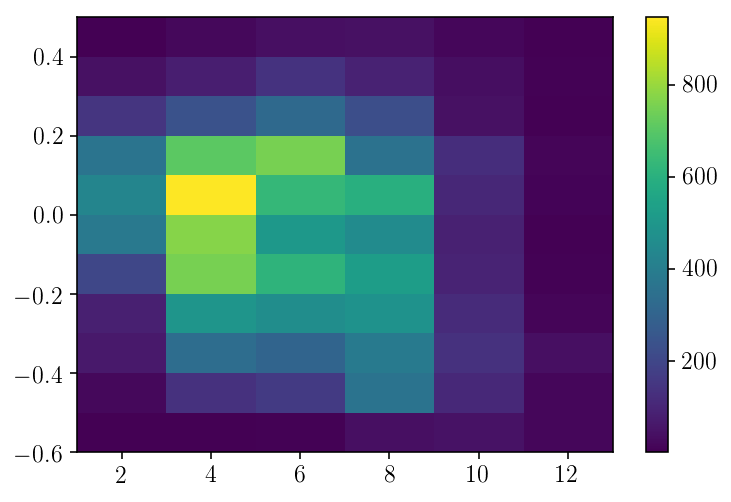

In [3]:
agebins = np.arange(1.,14.,2.)
fehbins = np.arange(-0.6,0.6,0.1)
fig = plt.hist2d(dat['Age'], dat['FE_H'], bins=[agebins,fehbins])
plt.colorbar()

In [13]:
isothermal_model = """
data {
    int<lower=0> N; //Number of sampled data points
    vector[N] vR; // radial velocities
    vector[N] vz; // vertical velocities
    vector[N] R; // radii
    vector[N] z; // heights
    vector[N] e_vR2;
    vector[N] e_vz2;
    real<lower=0> med_z; // median height
    real<lower=0> cont_sigma;
}
transformed data {
    vector[N] dz;
    vector<lower=0.>[N] contsigmaz;
    vector<lower=0.>[N] contsigmaR;
    dz = z-med_z;
    contsigmaz = sqrt(square(cont_sigma)+e_vz2);
    contsigmaR = sqrt(square(cont_sigma)+e_vR2);
}
parameters {
    real logsigmaR;
    real logsigmaz;
    real<lower=0., upper=1.> eta;
}
transformed parameters {
    vector[N] sigmaR_conv;
    vector[N] sigmaz_conv;
    real sigmaR;
    real sigmaz;
    simplex[2] theta;
    theta[1] = 1-eta;
    theta[2] = eta;
    sigmaR = 10^logsigmaR;
    sigmaz = 10^logsigmaz;
    sigmaR_conv = sqrt(square(sigmaR)+e_vR2);
    sigmaz_conv = sqrt(square(sigmaz)+e_vz2);
} 

model {
    vector[4] contributions;
    logsigmaR ~ normal(0.,1.);
    logsigmaz ~ normal(0.,1.);
    for (n in 1:N) {
        contributions[1] = log(theta[1])+ normal_lpdf(vR[n] | 0., sigmaR_conv[n]);
        contributions[2] = log(theta[2])+ normal_lpdf(vR[n] | 0., contsigmaR[n]);
        contributions[3] = log(theta[1])+ normal_lpdf(vz[n] | 0., sigmaz_conv[n]);
        contributions[4] = log(theta[2])+ normal_lpdf(vz[n] | 0., contsigmaz[n]);
        target += log_sum_exp(contributions);
    }
    
}
"""

isothermal_multi_norm = """
data {
    int<lower=0> N; //Number of sampled data points
    vector[2] vRvz[N]; // velocities
    vector[N] R; // radii
    vector[N] z; // heights
    matrix[3,3] cov_galcencyl[N]; // radial velocity error squared
    real<lower=0> med_z; // median height
    real<lower=0> cont_sigma; // velocity dispersion of interloper func
}
transformed data {
    vector[N] dz;
    dz = z-med_z;
}
parameters {
    real logsigmaR;
    real logsigmaz;
    real<lower=0., upper=1.> eta;
    real logalpha;
}
transformed parameters {
    real sigmaR;
    real sigmaRz;
    real sigmaz;
    real tana;
    real alpha;
    simplex[2] theta;
    theta[1] = 1-eta;
    theta[2] = eta;
    sigmaR = 10^logsigmaR;
    sigmaz = 10^logsigmaz;
    alpha = 10^logalpha;
    tana = tan(alpha);
    sigmaRz = sqrt((sigmaR^2+sigmaz^2)*(tana/(1-tana^2)));
} 

model {
    vector[2] contributions;
    matrix[2,2] cov;
    matrix[2,2] contcov;
    vector[2] v0;
    v0[1] = 0;
    v0[2] = 0;
    logsigmaR ~ normal(0.,1.);
    logsigmaz ~ normal(0.,1.);
    for (n in 1:N) {
        cov[1,1] = sigmaR^2+cov_galcencyl[n,1,1];
        cov[1,2] = sigmaRz^2+cov_galcencyl[n,1,3];
        cov[2,1] = sigmaRz^2+cov_galcencyl[n,1,3];
        cov[2,2] = sigmaz^2+cov_galcencyl[n,3,3];
        contcov[1,1] = cont_sigma^2+cov_galcencyl[n,1,1];
        contcov[1,2] = cov_galcencyl[n,1,3];
        contcov[2,1] = cov_galcencyl[n,1,3];
        contcov[2,2] = cont_sigma^2+cov_galcencyl[n,3,3];
        contributions[1] = log(theta[1])+ multi_normal_lpdf(vRvz[n] | v0, cov);
        contributions[2] = log(theta[2])+ multi_normal_lpdf(vRvz[n] | v0, contcov);
        target += log_sum_exp(contributions);
    }
    
}
"""

gaussian_expRquadz = """
data {
    int<lower=0> N; //Number of sampled data points
    vector[N] vR; // radial velocities
    vector[N] vz; // vertical velocities
    vector[N] R; // radii
    vector[N] z; // heights
    vector[N] e_vR2; // radial velocity error squared
    vector[N] e_vz2; // vertical velocity error squared
    real<lower=0> med_z; // median height
    real<lower=0> cont_sigma; // velocity dispersion of interloper func
}
transformed data {
    vector[N] dz;
    vector<lower=0.>[N] contsigmaz;
    vector<lower=0.>[N] contsigmaR;
    dz = z-med_z;
    contsigmaz = sqrt(square(cont_sigma)+e_vz2);
    contsigmaR = sqrt(square(cont_sigma)+e_vR2);
}
parameters {
    real invhR; 
    real invhz;
    real taR;
    real tbR;
    real taz;
    real tbz;
    real<lower=0.> logsigmaR;
    real<lower=0.> logsigmaz;
    real<lower=0., upper=1.> eta;
}
transformed parameters {
    vector<lower=0.>[N] sigmaR_fRz;
    vector<lower=0.>[N] sigmaz_fRz;
    real aR;
    real bR;
    real az;
    real bz;
    real sigmaR;
    real sigmaz;
    real hR;
    real hz;
    simplex[2] theta;
    aR = taR;
    bR = tbR;
    az = taz;
    bz = tbz;
    sigmaR = 10^logsigmaR;
    sigmaz = 10^logsigmaz;
    hR = 1./invhR;
    hz = 1./invhz;
    theta[1] = 1-eta;
    theta[2] = eta;
    sigmaR_fRz = sqrt(square((aR*square(dz)+bR*dz+sigmaR).*exp(invhR*(R-8.)))+e_vR2);
    sigmaz_fRz = sqrt(square((az*square(dz)+bz*dz+sigmaz).*exp(invhz*(R-8.)))+e_vz2);
} 

model {
    vector[4] contributions;
    taR ~ normal(0., 10.);
    tbR ~ normal(0., 10.);
    taz ~ normal(0., 10.);
    tbz ~ normal(0., 10.);
    logsigmaR ~ normal(0., 1.);
    logsigmaz ~ normal(0., 1.);
    invhR ~ normal(0., 1.);
    invhz ~ normal(0., 1.);
    for (n in 1:N) {
        contributions[1] = log(theta[1])+ normal_lpdf(vR[n] | 0., sigmaR_fRz[n]);
        contributions[2] = log(theta[2])+ normal_lpdf(vR[n] | 0., contsigmaR[n]);
        contributions[3] = log(theta[1])+ normal_lpdf(vz[n] | 0., sigmaz_fRz[n]);
        contributions[4] = log(theta[2])+ normal_lpdf(vz[n] | 0., contsigmaz[n]);
        target += log_sum_exp(contributions);
    }
}
"""


gaussian_expRexpz = """
data {
    int<lower=0> N; //Number of sampled data points
    vector[N] vR; // radial velocities
    vector[N] vz; // vertical velocities
    vector[N] R; // radii
    vector[N] z; // heights
    vector[N] e_vR2; // radial velocity error squared
    vector[N] e_vz2; // vertical velocity error squared
    real<lower=0> med_z; // median height
    real<lower=0> cont_sigma; // velocity dispersion of interloper func
}
transformed data {
    vector[N] dz;
    vector<lower=0.>[N] contsigmaz;
    vector<lower=0.>[N] contsigmaR;
    dz = z-med_z;
    contsigmaz = sqrt(square(cont_sigma)+e_vz2);
    contsigmaR = sqrt(square(cont_sigma)+e_vR2);
}
parameters {
    real invhR_R; 
    real invhz_R;
    real invhR_z;
    real invhz_z;
    real logsigmaR;
    real logsigmaz;
    real<lower=0., upper=1.> eta;
}
transformed parameters {
    vector<lower=0.>[N] sigmaR_fRz;
    vector<lower=0.>[N] sigmaz_fRz;
    simplex[2] theta;
    real sigmaR;
    real sigmaz;
    sigmaR = 10^logsigmaR;
    sigmaz = 10^logsigmaz;
    theta[1] = 1-eta;
    theta[2] = eta;
    sigmaR_fRz = sqrt(square(sigmaR*(exp(invhR_R*(R-8.)+invhz_R*(dz)))+e_vR2));
    sigmaz_fRz = sqrt(square(sigmaz*(exp(invhR_z*(R-8.)+invhz_z*(dz)))+e_vz2));
} 

model {
    vector[4] contributions;
    logsigmaR ~ normal(1.5, 0.5);
    logsigmaz ~ normal(1.5, 0.5);
    invhR_R ~ normal(0., 1.);
    invhR_z ~ normal(0., 1.);
    invhz_R ~ normal(0., 1.);
    invhz_z ~ normal(0., 1.);
    for (n in 1:N) {
        contributions[1] = log(theta[1])+ normal_lpdf(vR[n] | 0., sigmaR_fRz[n]);
        contributions[2] = log(theta[2])+ normal_lpdf(vR[n] | 0., contsigmaR[n]);
        contributions[3] = log(theta[1])+ normal_lpdf(vz[n] | 0., sigmaz_fRz[n]);
        contributions[4] = log(theta[2])+ normal_lpdf(vz[n] | 0., contsigmaz[n]);
        target += log_sum_exp(contributions);
    }
}
"""

multi_norm_model = """
data {
    int<lower=0> N; //Number of sampled data points
    vector[2] vRvz[N]; // velocities
    vector[N] R; // radii
    vector[N] z; // heights
    matrix[3,3] cov_galcencyl[N]; // radial velocity error squared
    real<lower=0> med_z; // median height
    real<lower=0> cont_sigma; // velocity dispersion of interloper func
}
transformed data {
    vector[N] dz;
    dz = z-med_z;
}
parameters {
    real invhR; 
    real invhz;
    real aR;
    real bR;
    real az;
    real bz;
    real<lower=0.> logsigmaR;
    real<lower=0.> logsigmaz;
    real alpha_0;
    real alpha_1;
    real<lower=0., upper=1.> eta;    
} 
transformed parameters {
    vector<lower=0.>[N] sigmaR_fRz;
    vector<lower=0.>[N] sigmaz_fRz;
    vector[N] tana;
    real sigmaR;
    real sigmaz;
    real hR;
    real hz;
    real alpha;
    simplex[2] theta;
    sigmaR = 10^logsigmaR;
    sigmaz = 10^logsigmaz;
    hR = 1./invhR;
    hz = 1./invhz;
    theta[1] = 1-eta;
    theta[2] = eta;
    tana = alpha_0+alpha_1*(z ./ R);
    alpha = atan(alpha_0);
    sigmaR_fRz = square((aR*square(dz)+bR*dz+sigmaR).*exp(invhR*(R-8.)));
    sigmaz_fRz = square((az*square(dz)+bz*dz+sigmaz).*exp(invhz*(R-8.)));
}
model {
    vector[2] contributions;
    matrix[2,2] cov;
    matrix[2,2] contcov;
    vector[2] v0;
    real sigmaRz_fRz;
    v0[1] = 0.;
    v0[2] = 0.;
    aR ~ normal(0., 10.);
    bR ~ normal(0., 10.);
    az ~ normal(0., 10.);
    bz ~ normal(0., 10.);
    alpha_0 ~ normal(0.,1.);
    alpha_1 ~ normal(0.,1.);
    logsigmaR ~ normal(0., 1.);
    logsigmaz ~ normal(0., 1.);
    invhR ~ normal(0., 1.);
    invhz ~ normal(0., 1.);
    for (n in 1:N) {
        sigmaRz_fRz = (square(sigmaR_fRz[n])-square(sigmaz_fRz[n]))*(tana[n]/1-tana[n]^2);
        cov[1,1] = square(sigmaR_fRz[n])+cov_galcencyl[n,1,1];
        cov[1,2] = sigmaRz_fRz+cov_galcencyl[n,1,3];
        cov[2,1] = sigmaRz_fRz+cov_galcencyl[n,1,3];
        cov[2,2] = square(sigmaz_fRz[n])+cov_galcencyl[n,3,3];
        contcov[1,1] = cont_sigma^2+cov_galcencyl[n,1,1];
        contcov[1,2] = cov_galcencyl[n,1,3];
        contcov[2,1] = cov_galcencyl[n,1,3];
        contcov[2,2] = cont_sigma^2+cov_galcencyl[n,3,3];
        contributions[1] = log(theta[1])+ multi_normal_lpdf(vRvz[n] | v0, cov);
        contributions[2] = log(theta[2])+ multi_normal_lpdf(vRvz[n] | v0, contcov);
        target += log_sum_exp(contributions);
    }
}
"""


multi_norm_model_test = """
data {
    int<lower=0> N; //Number of sampled data points
    vector[2] vRvz[N]; // velocities
    vector[N] R; // radii
    vector[N] z; // heights
    matrix[3,3] cov_galcencyl[N]; // radial velocity error squared
    real<lower=0> med_z; // median height
    real<lower=0> cont_sigma; // velocity dispersion of interloper func
}
transformed data {
    vector[N] dz;
    dz = z-med_z;
}
parameters {
    real invhR; 
    real invhz;
    real invhRz;
    real aR;
    real bR;
    real az;
    real bz;
    real aRz;
    real bRz;
    real<lower=0.> logsigmaR;
    real<lower=0.> logsigmaz;
    real logsigmaRz;
    real<lower=0., upper=1.> eta;    
} 
transformed parameters {
    vector<lower=0.>[N] sigmaR_fRz;
    vector<lower=0.>[N] sigmaz_fRz;
    vector[N] sigmaRz_fRz;
    vector[N] tana;
    real sigmaR;
    real sigmaz;
    real sigmaRz;
    real hR;
    real hz;
    simplex[2] theta;
    sigmaR = 10^logsigmaR;
    sigmaz = 10^logsigmaz;
    sigmaRz = 10^logsigmaRz;
    hR = 1./invhR;
    hz = 1./invhz;
    theta[1] = 1-eta;
    theta[2] = eta;
    sigmaRz_fRz = square((aRz*square(dz)+bRz*dz+sigmaRz).*exp(invhRz*(R-8.)));
    sigmaR_fRz = square((aR*square(dz)+bR*dz+sigmaR).*exp(invhR*(R-8.)));
    sigmaz_fRz = square((az*square(dz)+bz*dz+sigmaz).*exp(invhz*(R-8.)));
}
model {
    vector[2] contributions;
    matrix[2,2] cov;
    matrix[2,2] contcov;
    vector[2] v0;
    v0[1] = 0.;
    v0[2] = 0.;
    aR ~ normal(0., 10.);
    bR ~ normal(0., 10.);
    az ~ normal(0., 10.);
    bz ~ normal(0., 10.);
    aRz ~ normal(0., 10.);
    bRz ~ normal(0., 10.);
    logsigmaR ~ normal(0., 1.);
    logsigmaz ~ normal(0., 1.);
    logsigmaRz ~ normal(0., 1.) T[-;
    invhR ~ normal(0., 1.);
    invhz ~ normal(0., 1.);
    invhRz ~ normal(0., 1.);
    for (n in 1:N) {
        cov[1,1] = sigmaR_fRz[n]^2+cov_galcencyl[n,1,1];
        cov[1,2] = sigmaRz_fRz[n]^2+cov_galcencyl[n,1,3];
        cov[2,1] = sigmaRz_fRz[n]^2+cov_galcencyl[n,1,3];
        cov[2,2] = sigmaz_fRz[n]^2+cov_galcencyl[n,3,3];
        contcov[1,1] = cont_sigma^2+cov_galcencyl[n,1,1];
        contcov[1,2] = cov_galcencyl[n,1,3];
        contcov[2,1] = cov_galcencyl[n,1,3];
        contcov[2,2] = cont_sigma^2+cov_galcencyl[n,3,3];
        contributions[1] = log(theta[1])+ multi_normal_lpdf(vRvz[n] | v0, cov);
        contributions[2] = log(theta[2])+ multi_normal_lpdf(vRvz[n] | v0, contcov);
        target += log_sum_exp(contributions);
    }
}
"""


"""    \\vector<lower=0.,upper=300.>[N] sigmaR0;
    \\vector<lower=0.,upper=300.>[N] sigmaz0;
    \\sigmaR0 = sqrt(square(aR*square(0.-med_z)+bR*(0.-med_z)+exp(logsigmaR))+e_vR2);
    \\sigmaz0 = sqrt(square(az*square(0.-med_z)+bz*(0.-med_z)+exp(logsigmaz))+e_vz2);
        aR ~ normal(0., 60.);
    bR ~ normal(0., 60.);
    az ~ normal(0., 60.);
    bz ~ normal(0., 60.);
        real<upper = 0> discriminantR;
    real<upper = 0> discriminantz;
        discriminantR = bR^2-4*aR*sigmaR;
    discriminantz = bz^2-4*az*sigmaz;
    sigmaRz_fRz = (square(sigmaR_fRz[n])-square(sigmaR_fRz[n]))*(tana[n]/(1-square(tana[n])));
    
    alpha_0 ~ normal(0.,30.);
    alpha_1 ~ normal(0.,30.);"""

'    \\vector<lower=0.,upper=300.>[N] sigmaR0;\n    \\vector<lower=0.,upper=300.>[N] sigmaz0;\n    \\sigmaR0 = sqrt(square(aR*square(0.-med_z)+bR*(0.-med_z)+exp(logsigmaR))+e_vR2);\n    \\sigmaz0 = sqrt(square(az*square(0.-med_z)+bz*(0.-med_z)+exp(logsigmaz))+e_vz2);\n        aR ~ normal(0., 60.);\n    bR ~ normal(0., 60.);\n    az ~ normal(0., 60.);\n    bz ~ normal(0., 60.);\n        real<upper = 0> discriminantR;\n    real<upper = 0> discriminantz;\n        discriminantR = bR^2-4*aR*sigmaR;\n    discriminantz = bz^2-4*az*sigmaz;\n    sigmaRz_fRz = (square(sigmaR_fRz[n])-square(sigmaR_fRz[n]))*(tana[n]/(1-square(tana[n])));\n    \n    alpha_0 ~ normal(0.,30.);\n    alpha_1 ~ normal(0.,30.);'

In [14]:
sm = pystan.StanModel(model_code=isothermal_multi_norm)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cf468a4a14ca5dfa810dc9ce29c61fea NOW.


In [48]:
nit = 5000
nchain = 4
nsamples = int((nit/2)*nchain)
pars=['invhR', 'aR', 'bR', 'invhz', 'az', 'bz', 'sigmaR', 'sigmaz', 'eta']
#pars = ['invhR_R', 'invhz_R', 'invhR_z', 'invhz_z', 'sigmaR', 'sigmaz', 'eta']
#pars = ['sigmaR', 'sigmaz', 'eta']
agebins = np.arange(1.,14.,2.)
fehbins = np.arange(-0.6,0.6,0.1)
tlo_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
thi_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
tsamp_arrs = [tlo_samples, thi_samples]
labels = ['low', 'high']
i=3
j=5
print(str(agebins[i])+' < Age < '+str(agebins[i+1])+'  '+str(round(fehbins[j],2))+' < [Fe/H] < '+str(round(fehbins[j+1],2)))
lo_m = [(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] < define_rgbtgassample.alphaedge(dat['FE_H'])) & (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
hi_m = [(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] >= define_rgbtgassample.alphaedge(dat['FE_H']))& (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
m = [lo_m, hi_m]
for ii,mask in enumerate(m):
    v_R = vRvTvz[:,0][mask]*220.
    v_z = vRvTvz[:,2][mask]*220.
    R = Rpz[:,0][mask]*8.
    z = Rpz[:,2][mask]*8.
    e_vR2 = cov_galcencyl[:,0,0][mask]
    e_vz2 = cov_galcencyl[:,2,2][mask]
    print(len(v_R))
    if len(v_R) < 100:
        print('not enough samples in '+labels[ii]+' alpha...')
    else:
        dat_dict = {'N': len(v_R),
                    'vR': v_R,
                    'vz': v_z,
                    'R': R,
                    'z': np.fabs(z),
                    'e_vR2': e_vR2,
                    'e_vz2': e_vz2,
                    'med_z': np.mean(np.fabs(z)),
                    'cont_sigma': 100.}
        print('sampling '+labels[ii]+' alpha...')
        fit = sm.sampling(data=dat_dict, iter=nit, chains=nchain, verbose=True)
        extr = fit.extract(pars=pars, permuted=True)
        samples = np.empty([nsamples,len(pars)])
        for k in range(len(pars)):
            samples[:,k] = extr[pars[k]]
        print('sample means:'+np.str(np.mean(samples, axis=0)))
        tsamp_arrs[ii][i,j] = samples

7.0 < Age < 9.0  -0.1 < [Fe/H] < -0.0
141
sampling low alpha...
/home/astjmack/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):

sample means:[-3.64948584e-01 -3.80506782e+00 -1.71142051e+00 -5.75243787e-01
  4.72765390e+00  2.89983271e+00  3.63006860e+01  1.76130544e+01
  1.71266183e-02]
226
sampling high alpha...
sample means:[-1.37001174e-01 -2.28675960e-01  3.62594392e+00  7.68273607e-02
  1.55418580e+01  2.11482611e+00  4.89808906e+01  1.78087867e+01
  1.04171670e-02]


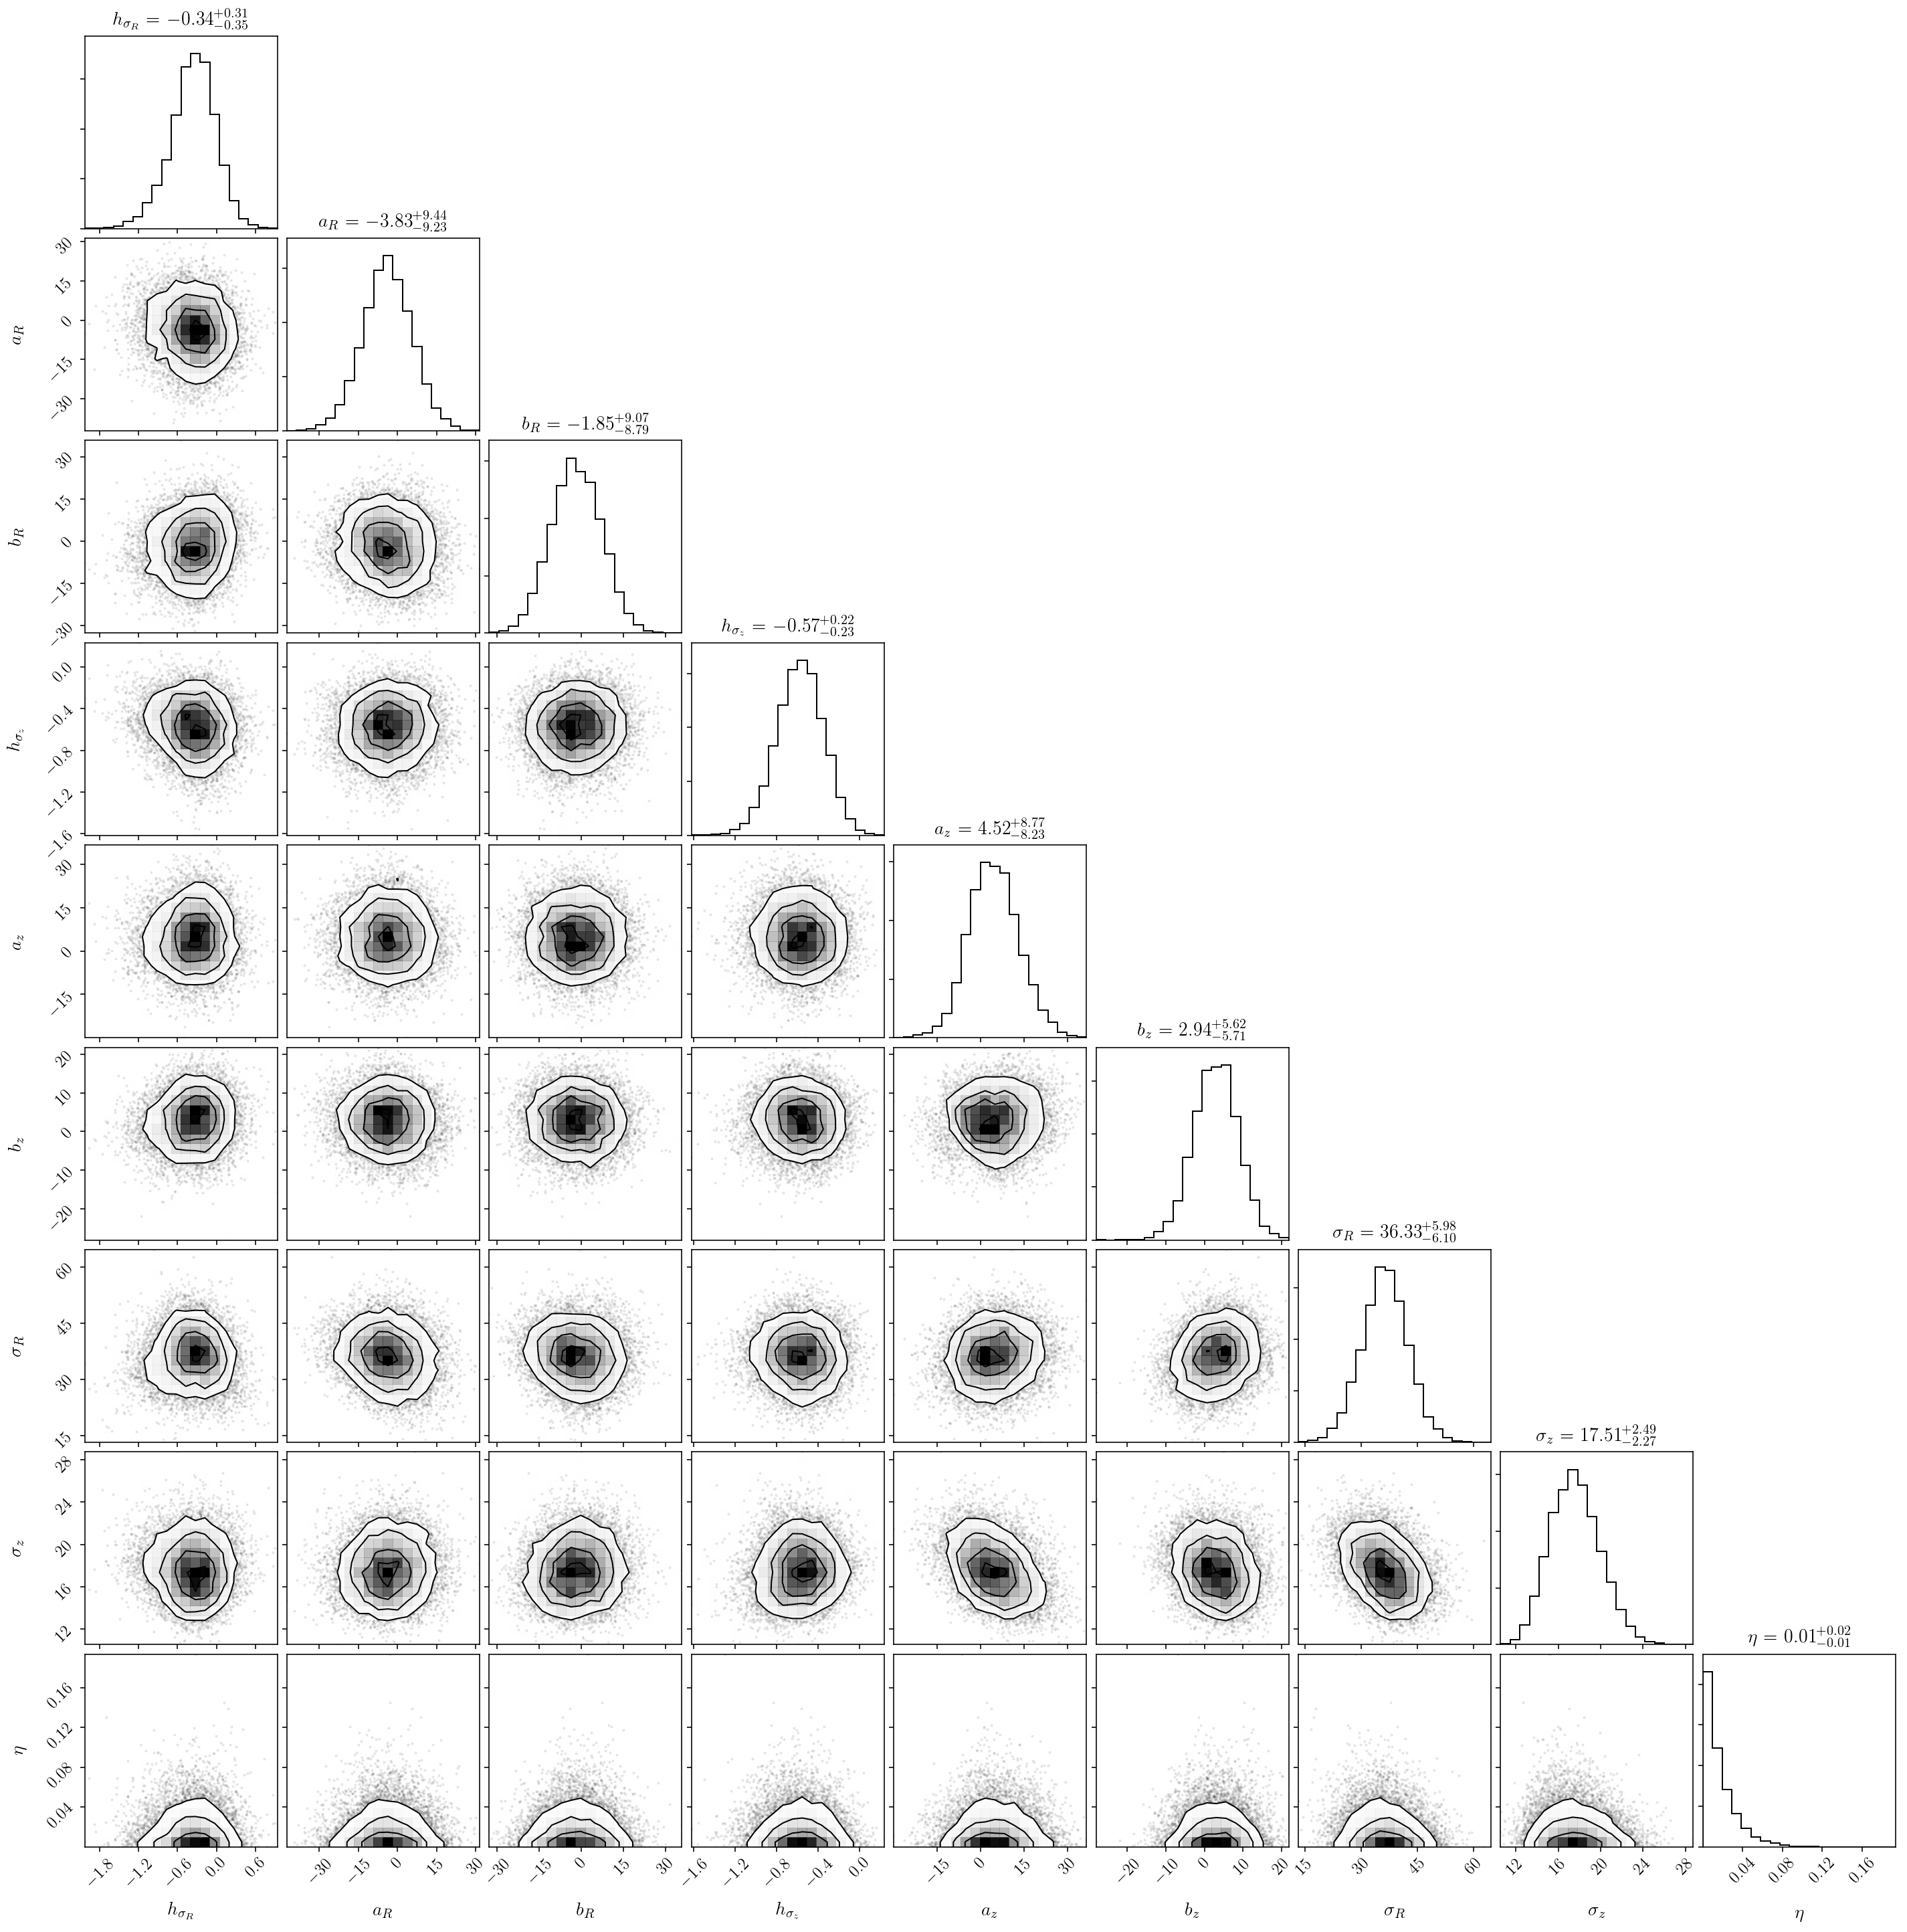

In [49]:
labels =[r'$h_{\sigma_{R}}$', r'$a_R$', r'$b_R$', r'$h_{\sigma_{z}}$', r'$a_z$', r'$b_z$', r'$\sigma_{R}$', r'$\sigma_{z}$', r'$\eta$']
#labels =[r'$h_{R,\sigma_{R}}$', r'$h_{z,\sigma_{R}}$', r'$h_{R,\sigma_{z}}^{-1}\ \mathrm{[kpc^{-1}]}$', r'$h_{z,\sigma_{z}}^{-1}\ \mathrm{[kpc^{-1}]}$', r'$\sigma_{R}$', r'$\sigma_{z}$', r'$\eta$']
#labels = [r'$\sigma_{R}$', r'$\sigma_{z}$', r'$\eta$']
fig = corner.corner(tsamp_arrs[0][i,j], labels = labels, show_titles=True)

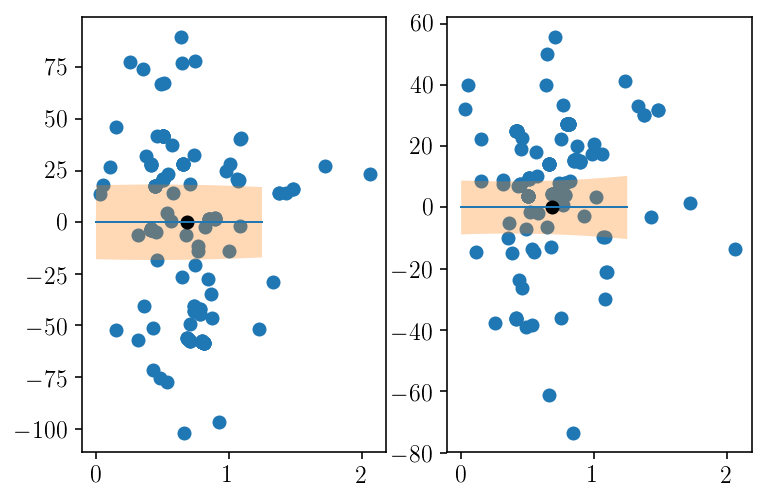

In [50]:
def sigma_fz(z, sigma, a, b, med_z):
    return sigma+b*(z-med_z)+a*(z-med_z)**2

def sigma_fz_exp(z, sigma, h, med_z):
    return sigma*np.exp(h*(z-med_z))

exp = False

params =np.median(tsamp_arrs[0][i,j], axis=0)
percentiles = np.percentile(tsamp_arrs[0][i,j], [16,84], axis=0)
mask = lo_m
fig, ax = plt.subplots(1,2)

v_R = vRvTvz[:,0][mask]*220.
v_z = vRvTvz[:,2][mask]*220.
R = Rpz[:,0][mask]*8.
z = Rpz[:,2][mask]*8.
e_vR2 = cov_galcencyl[:,0,0][mask]
e_vz2 = cov_galcencyl[:,2,2][mask]
ax[0].scatter(np.fabs(z),v_R)
zs = np.linspace(0.,1.25)
if exp:
    sigmafz = sigma_fz_exp(zs, params[4], params[1], np.median(np.fabs(z)))
else:
    sigmafz = sigma_fz(zs, params[6], params[1], params[2], np.median(np.fabs(z)))
ax[0].plot(zs, np.zeros(len(zs)))
ax[0].fill_between(zs, 0+sigmafz/2., 0-sigmafz/2., alpha=0.3)
ax[0].scatter(np.median(np.fabs(z)), 0, c='Black')

ax[1].scatter(np.fabs(z),v_z)
zs = np.linspace(0.,1.25)
if exp:
    sigmafz = sigma_fz_exp(zs, params[5], params[3], np.median(np.fabs(z)))
else:
    sigmafz = sigma_fz(zs, params[7], params[4], params[5], np.median(np.fabs(z)))
ax[1].plot(zs, np.zeros(len(zs)))
ax[1].fill_between(zs, 0+sigmafz/2., 0-sigmafz/2., alpha=0.3)
ax[1].scatter(np.median(np.fabs(z)), 0, c='Black')

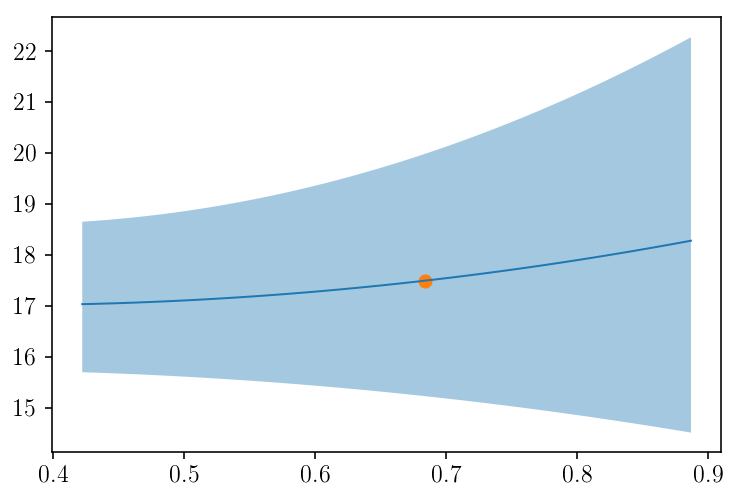

In [52]:
zs = np.linspace(np.percentile(np.fabs(z),16), np.percentile(np.fabs(z),84), 100)
sigma_med_z = sigma_fz(np.median(np.fabs(z)), params[7], params[4], params[5], np.median(np.fabs(z)))
sigmafz = sigma_fz(zs, params[7], params[4], params[5], np.median(np.fabs(z)))
sigmafz_lo = sigma_fz(zs, percentiles[0,7], percentiles[0,4], percentiles[0,5], np.median(np.fabs(z)))
sigmafz_hi = sigma_fz(zs, percentiles[1,7], percentiles[1,4], percentiles[1,5], np.median(np.fabs(z)))
plt.plot(zs, sigmafz)
plt.fill_between(zs, sigmafz_lo, sigmafz_hi, alpha=0.4)
plt.scatter(np.median(np.fabs(z)), sigma_med_z)

In [56]:
params[8], params[4], params[5]

(4.066394311634706, 41.35725764957832, -2.5715464201289775)

In [173]:
nit = 5000
nchain = 4
nsamples = int((nit/2)*nchain)
#pars=['invhR', 'aR', 'bR', 'invhz', 'az', 'bz', 'logsigmaR','v_R0', 'logsigmaz', 'v_z0', 'eta']
#pars = ['invhR_R', 'invhz_R', 'invhR_z', 'invhz_z', 'sigmaR', 'sigmaz', 'eta']
pars = ['sigmaR', 'sigmaz', 'eta']
agebins = np.arange(1.,14.,2.)
fehbins = np.arange(-0.6,0.6,0.1)
lo_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
hi_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
samp_arrs = [lo_samples, hi_samples]
labels = ['low', 'high']
for i in range(len(agebins)-1):
    for j in range(len(fehbins)-1):
        print(str(i)+','+str(j)+' '+str(agebins[i])+' < Age < '+str(agebins[i+1])+'  '+str(round(fehbins[j],2))+' < [Fe/H] < '+str(round(fehbins[j+1],2)))
        lo_m = [(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] < define_rgbtgassample.alphaedge(dat['FE_H'])) & (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
        hi_m = [(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] >= define_rgbtgassample.alphaedge(dat['FE_H']))& (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
        m = [lo_m, hi_m]
        for ii,mask in enumerate(m):
            v_R = vRvTvz[:,0][mask]*220.
            v_z = vRvTvz[:,2][mask]*220.
            R = Rpz[:,0][mask]*8.
            z = Rpz[:,2][mask]*8.
            e_vR2 = cov_galcencyl[:,0,0][mask]
            e_vz2 = cov_galcencyl[:,2,2][mask]
            if len(v_R) < 100:
                print('not enough samples in '+labels[ii]+' alpha...')
            else:
                dat_dict = {'N': len(v_R),
                            'vR': v_R,
                            'vz': v_z,
                            'R': R,
                            'z': np.fabs(z),
                            'e_vR2': e_vR2,
                            'e_vz2': e_vz2,
                            'med_z': np.median(np.fabs(z)),
                            'cont_sigma': 100.}
                print('sampling '+labels[ii]+' alpha...')
                fit = sm.sampling(data=dat_dict, iter=nit, chains=nchain, verbose=True)
                extr = fit.extract(pars=pars, permuted=True)
                samples = np.empty([nsamples,len(pars)])
                for k in range(len(pars)):
                    samples[:,k] = extr[pars[k]]
                print('sample means:'+np.str(np.mean(samples, axis=0)))
                samp_arrs[ii][i,j] = samples
with open('../sav/gaussian_isothermal_stanfit.npy', 'wb') as f:
    np.save(f, lo_samples)
    np.save(f, hi_samples)
    np.save(f, agebins)
    np.save(f, fehbins)
print(str(agebins[i])+' < Age < '+str(agebins[i+1])+'  '+str(round(fehbins[j],2))+' < [Fe/H] < '+str(round(fehbins[j+1],2)))


0,0 1.0 < Age < 3.0  -0.6 < [Fe/H] < -0.5
not enough samples in low alpha...
not enough samples in high alpha...
0,1 1.0 < Age < 3.0  -0.5 < [Fe/H] < -0.4
not enough samples in low alpha...
not enough samples in high alpha...
0,2 1.0 < Age < 3.0  -0.4 < [Fe/H] < -0.3
not enough samples in low alpha...
not enough samples in high alpha...
0,3 1.0 < Age < 3.0  -0.3 < [Fe/H] < -0.2
not enough samples in low alpha...
not enough samples in high alpha...
0,4 1.0 < Age < 3.0  -0.2 < [Fe/H] < -0.1
sampling low alpha...
/home/astjmack/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):

sample means:[14.24999807 12.80239076  0.01996125]
not enough samples in high alpha...
0,5 1.0 < Age < 3.0  -0.1 < [Fe/H] < -0.0
sampling low alpha...
sample means:[1.74082474e+01 1

11.0 < Age < 13.0  0.4 < [Fe/H] < 0.5


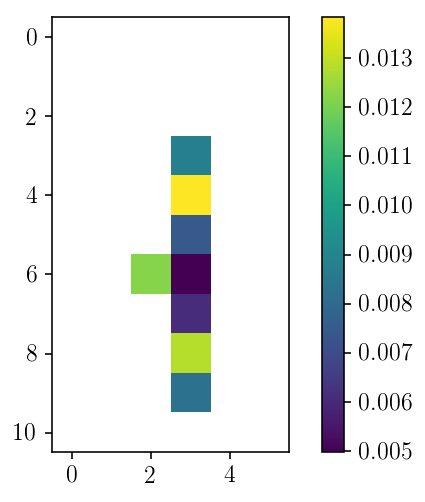

In [184]:
plt.imshow(np.rot90(np.median(hi_samples, axis=2)[:,:,2]))
plt.colorbar()

In [181]:
np.shape(lo_samples)

(6, 11, 10000, 3)

In [115]:
e_vR2

array([], dtype=float64)

In [124]:
np.max(np.sqrt(cov_galcencyl[:,0,0]))

100.31199103198985

In [126]:
len(np.sqrt(cov_galcencyl[:,0,0])[np.sqrt(cov_galcencyl[:,0,0]) < 10])

12244

## M

In [55]:
nit = 5000
nchain = 4
nsamples = int((nit/2)*nchain)
pars=['invhR', 'aR', 'bR', 'invhz', 'az', 'bz', 'sigmaR', 'sigmaz', 'eta']
#pars = ['invhR_R', 'invhz_R', 'invhR_z', 'invhz_z', 'sigmaR', 'sigmaz', 'eta']
#pars = ['sigmaR', 'sigmaz', 'eta']
agebins = np.arange(-0.1,0.5,0.1)
fehbins = np.arange(-0.6,0.6,0.1)
tlo_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
thi_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
tsamp_arrs = [tlo_samples, thi_samples]
labels = ['low', 'high']
i=3
j=2
print(str(agebins[i])+' < Age < '+str(agebins[i+1])+'  '+str(round(fehbins[j],2))+' < [Fe/H] < '+str(round(fehbins[j+1],2)))
lo_m = [(dat['AVG_ALPHAFE'] > agebins[i]) & (dat['AVG_ALPHAFE'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
hi_m = [(dat['AVG_ALPHAFE'] > agebins[i]) & (dat['AVG_ALPHAFE'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
m = [lo_m, hi_m]
for ii,mask in enumerate(m):
    v_R = vRvTvz[:,0][mask]*220.
    v_z = vRvTvz[:,2][mask]*220.
    R = Rpz[:,0][mask]*8.
    z = Rpz[:,2][mask]*8.
    e_vR2 = cov_galcencyl[:,0,0][mask]
    e_vz2 = cov_galcencyl[:,2,2][mask]
    print(len(v_R))
    if len(v_R) < 100:
        print('not enough samples in '+labels[ii]+' alpha...')
    else:
        dat_dict = {'N': len(v_R),
                    'vR': v_R,
                    'vz': v_z,
                    'R': R,
                    'z': np.fabs(z),
                    'e_vR2': e_vR2,
                    'e_vz2': e_vz2,
                    'med_z': np.mean(np.fabs(z)),
                    'cont_sigma': 100.}
        print('sampling '+labels[ii]+' alpha...')
        fit = sm.sampling(data=dat_dict, iter=nit, chains=nchain, verbose=True)
        extr = fit.extract(pars=pars, permuted=True)
        samples = np.empty([nsamples,len(pars)])
        for k in range(len(pars)):
            samples[:,k] = extr[pars[k]]
        print('sample means:'+np.str(np.mean(samples, axis=0)))
        tsamp_arrs[ii][i,j] = samples

0.20000000000000004 < Age < 0.30000000000000004  -0.4 < [Fe/H] < -0.3
118
sampling low alpha...
/home/astjmack/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):

sample means:[ 3.96360284e-01  4.26520450e+00  5.22069809e-01 -2.85775379e-01
  6.21628670e+00  1.85397928e+00  2.30104699e+01  3.81806648e+01
  3.27770446e-02]
118
sampling high alpha...
sample means:[ 4.27949906e-01  3.86866722e+00  1.19227631e+00 -2.80910096e-01
  6.36132248e+00  1.86357277e+00  2.24354878e+01  3.81383359e+01
  3.25629436e-02]


In [59]:
nit = 5000
nchain = 4
nsamples = int((nit/2)*nchain)
pars=['invhR', 'aR', 'bR', 'invhz', 'az', 'bz', 'sigmaR','sigmaz', 'eta']
#pars = ['invhR_R', 'invhz_R', 'invhR_z', 'invhz_z', 'sigmaR', 'sigmaz', 'eta']
#pars = ['sigmaR', 'sigmaz', 'eta']
agebins = np.arange(-0.1,0.45,0.05)
fehbins = np.arange(-0.6,0.6,0.1)
samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
for i in range(len(agebins)-1):
    for j in range(len(fehbins)-1):
        print(str(i)+','+str(j)+' '+str(agebins[i])+' < [a/Fe] < '+str(agebins[i+1])+'  '+str(round(fehbins[j],2))+' < [Fe/H] < '+str(round(fehbins[j+1],2)))
        mask = [(dat['AVG_ALPHAFE'] > agebins[i]) & (dat['AVG_ALPHAFE'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] < define_rgbtgassample.alphaedge(dat['FE_H'])) & (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
        v_R = vRvTvz[:,0][mask]*220.
        v_z = vRvTvz[:,2][mask]*220.
        R = Rpz[:,0][mask]*8.
        z = Rpz[:,2][mask]*8.
        e_vR2 = cov_galcencyl[:,0,0][mask]
        e_vz2 = cov_galcencyl[:,2,2][mask]
        if len(v_R) < 100:
            print('not enough samples... ('+str(len(v_R))+')')
        else:
            dat_dict = {'N': len(v_R),
                        'vR': v_R,
                        'vz': v_z,
                        'R': R,
                        'z': np.fabs(z),
                        'e_vR2': e_vR2,
                        'e_vz2': e_vz2,
                        'med_z': np.mean(np.fabs(z)),
                        'cont_sigma': 100.}
            print('sampling ... ('+str(len(v_R))+')')
            fit = sm.sampling(data=dat_dict, iter=nit, chains=nchain, verbose=True)
            extr = fit.extract(pars=pars, permuted=True)
            tsamples = np.empty([nsamples,len(pars)])
            for k in range(len(pars)):
                tsamples[:,k] = extr[pars[k]]
            print('sample means:'+np.str(np.mean(tsamples, axis=0)))
            samples[i,j] = tsamples
with open('../sav/gaussian_expRquadz_monoabundance_stanfit.npy', 'wb') as f:
    np.save(f, samples)
    np.save(f, agebins)
    np.save(f, fehbins)



0,0 -0.1 < [a/Fe] < -0.05  -0.6 < [Fe/H] < -0.5
not enough samples... (0)
0,1 -0.1 < [a/Fe] < -0.05  -0.5 < [Fe/H] < -0.4
not enough samples... (0)
0,2 -0.1 < [a/Fe] < -0.05  -0.4 < [Fe/H] < -0.3
not enough samples... (0)
0,3 -0.1 < [a/Fe] < -0.05  -0.3 < [Fe/H] < -0.2
not enough samples... (1)
0,4 -0.1 < [a/Fe] < -0.05  -0.2 < [Fe/H] < -0.1
not enough samples... (1)
0,5 -0.1 < [a/Fe] < -0.05  -0.1 < [Fe/H] < -0.0
not enough samples... (8)
0,6 -0.1 < [a/Fe] < -0.05  -0.0 < [Fe/H] < 0.1
not enough samples... (49)
0,7 -0.1 < [a/Fe] < -0.05  0.1 < [Fe/H] < 0.2
not enough samples... (37)
0,8 -0.1 < [a/Fe] < -0.05  0.2 < [Fe/H] < 0.3
not enough samples... (16)
0,9 -0.1 < [a/Fe] < -0.05  0.3 < [Fe/H] < 0.4
not enough samples... (2)
0,10 -0.1 < [a/Fe] < -0.05  0.4 < [Fe/H] < 0.5
not enough samples... (6)
1,0 -0.05 < [a/Fe] < 0.0  -0.6 < [Fe/H] < -0.5
not enough samples... (0)
1,1 -0.05 < [a/Fe] < 0.0  -0.5 < [Fe/H] < -0.4
not enough samples... (0)
1,2 -0.05 < [a/Fe] < 0.0  -0.4 < [Fe/H] < -0.

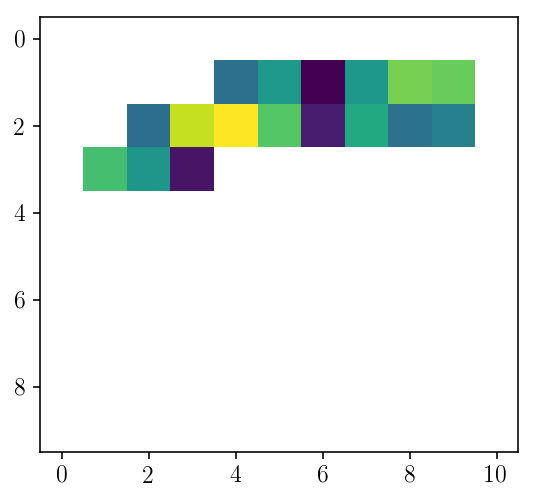

In [75]:
plt.imshow(np.median(samples, axis=2)[:,:,6])

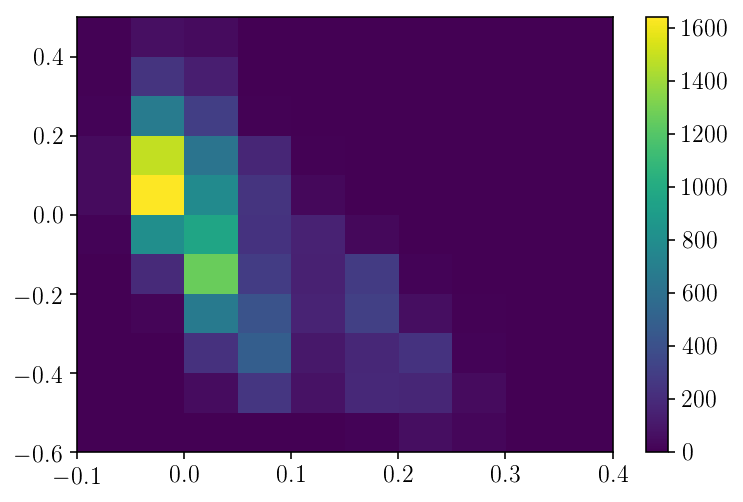

In [74]:

fig = plt.hist2d(dat['AVG_ALPHAFE'], dat['FE_H'], bins=[agebins,fehbins])
plt.colorbar()

In [8]:
nit = 5000
nchain = 4
nsamples = int((nit/2)*nchain)
pars=['invhR', 'aR', 'bR', 'invhz', 'az', 'bz', 'sigmaR', 'sigmaz','alpha_0', 'alpha_1', 'eta']
#pars = ['invhR_R', 'invhz_R', 'invhR_z', 'invhz_z', 'sigmaR', 'sigmaz', 'eta']
#pars = ['sigmaR', 'sigmaz', 'eta']
agebins = np.arange(1.,14.,2.)
fehbins = np.arange(-0.6,0.6,0.1)
tlo_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
thi_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
tsamp_arrs = [tlo_samples, thi_samples]
labels = ['low', 'high']
i=3
j=5
print(str(agebins[i])+' < Age < '+str(agebins[i+1])+'  '+str(round(fehbins[j],2))+' < [Fe/H] < '+str(round(fehbins[j+1],2)))
lo_m = [(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] < define_rgbtgassample.alphaedge(dat['FE_H'])) & (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
hi_m = [(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] >= define_rgbtgassample.alphaedge(dat['FE_H']))& (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
m = [lo_m, hi_m]
for ii,mask in enumerate(m):
    v_R = vRvTvz[:,0][mask]*220.
    v_z = vRvTvz[:,2][mask]*220.
    vRvz = np.dstack([v_R, v_z])[0]
    R = Rpz[:,0][mask]*8.
    z = Rpz[:,2][mask]*8.
    cov = cov_galcencyl[mask]
    print(len(v_R))
    if len(v_R) < 100:
        print('not enough samples in '+labels[ii]+' alpha...')
    else:
        dat_dict = {'N': len(v_R),
                    'vRvz': vRvz,
                    'R': R,
                    'z': np.fabs(z),
                    'cov_galcencyl': cov,
                    'med_z': np.mean(np.fabs(z)),
                    'cont_sigma': 100.}
        print('sampling '+labels[ii]+' alpha...')
        fit = sm.sampling(data=dat_dict, iter=nit, chains=nchain, verbose=True)
        extr = fit.extract(pars=pars, permuted=True)
        samples = np.empty([nsamples,len(pars)])
        for k in range(len(pars)):
            samples[:,k] = extr[pars[k]]
        print('sample means:'+np.str(np.mean(samples, axis=0)))
        tsamp_arrs[ii][i,j] = samples

7.0 < Age < 9.0  -0.1 < [Fe/H] < -0.0
141
sampling low alpha...


sample means:[-0.09039272 -0.60801143 -0.23643773 -0.11583323  1.33781319 -0.33535646
  6.50338486  4.50581949  0.49896624  0.01458959  0.02944101]
226
sampling high alpha...


sample means:[-0.03763427 -3.29131494  0.08537659  0.03829573  2.59099935  0.24321619
  7.8344129   5.01094654  0.80135512  0.28948938  0.02775792]


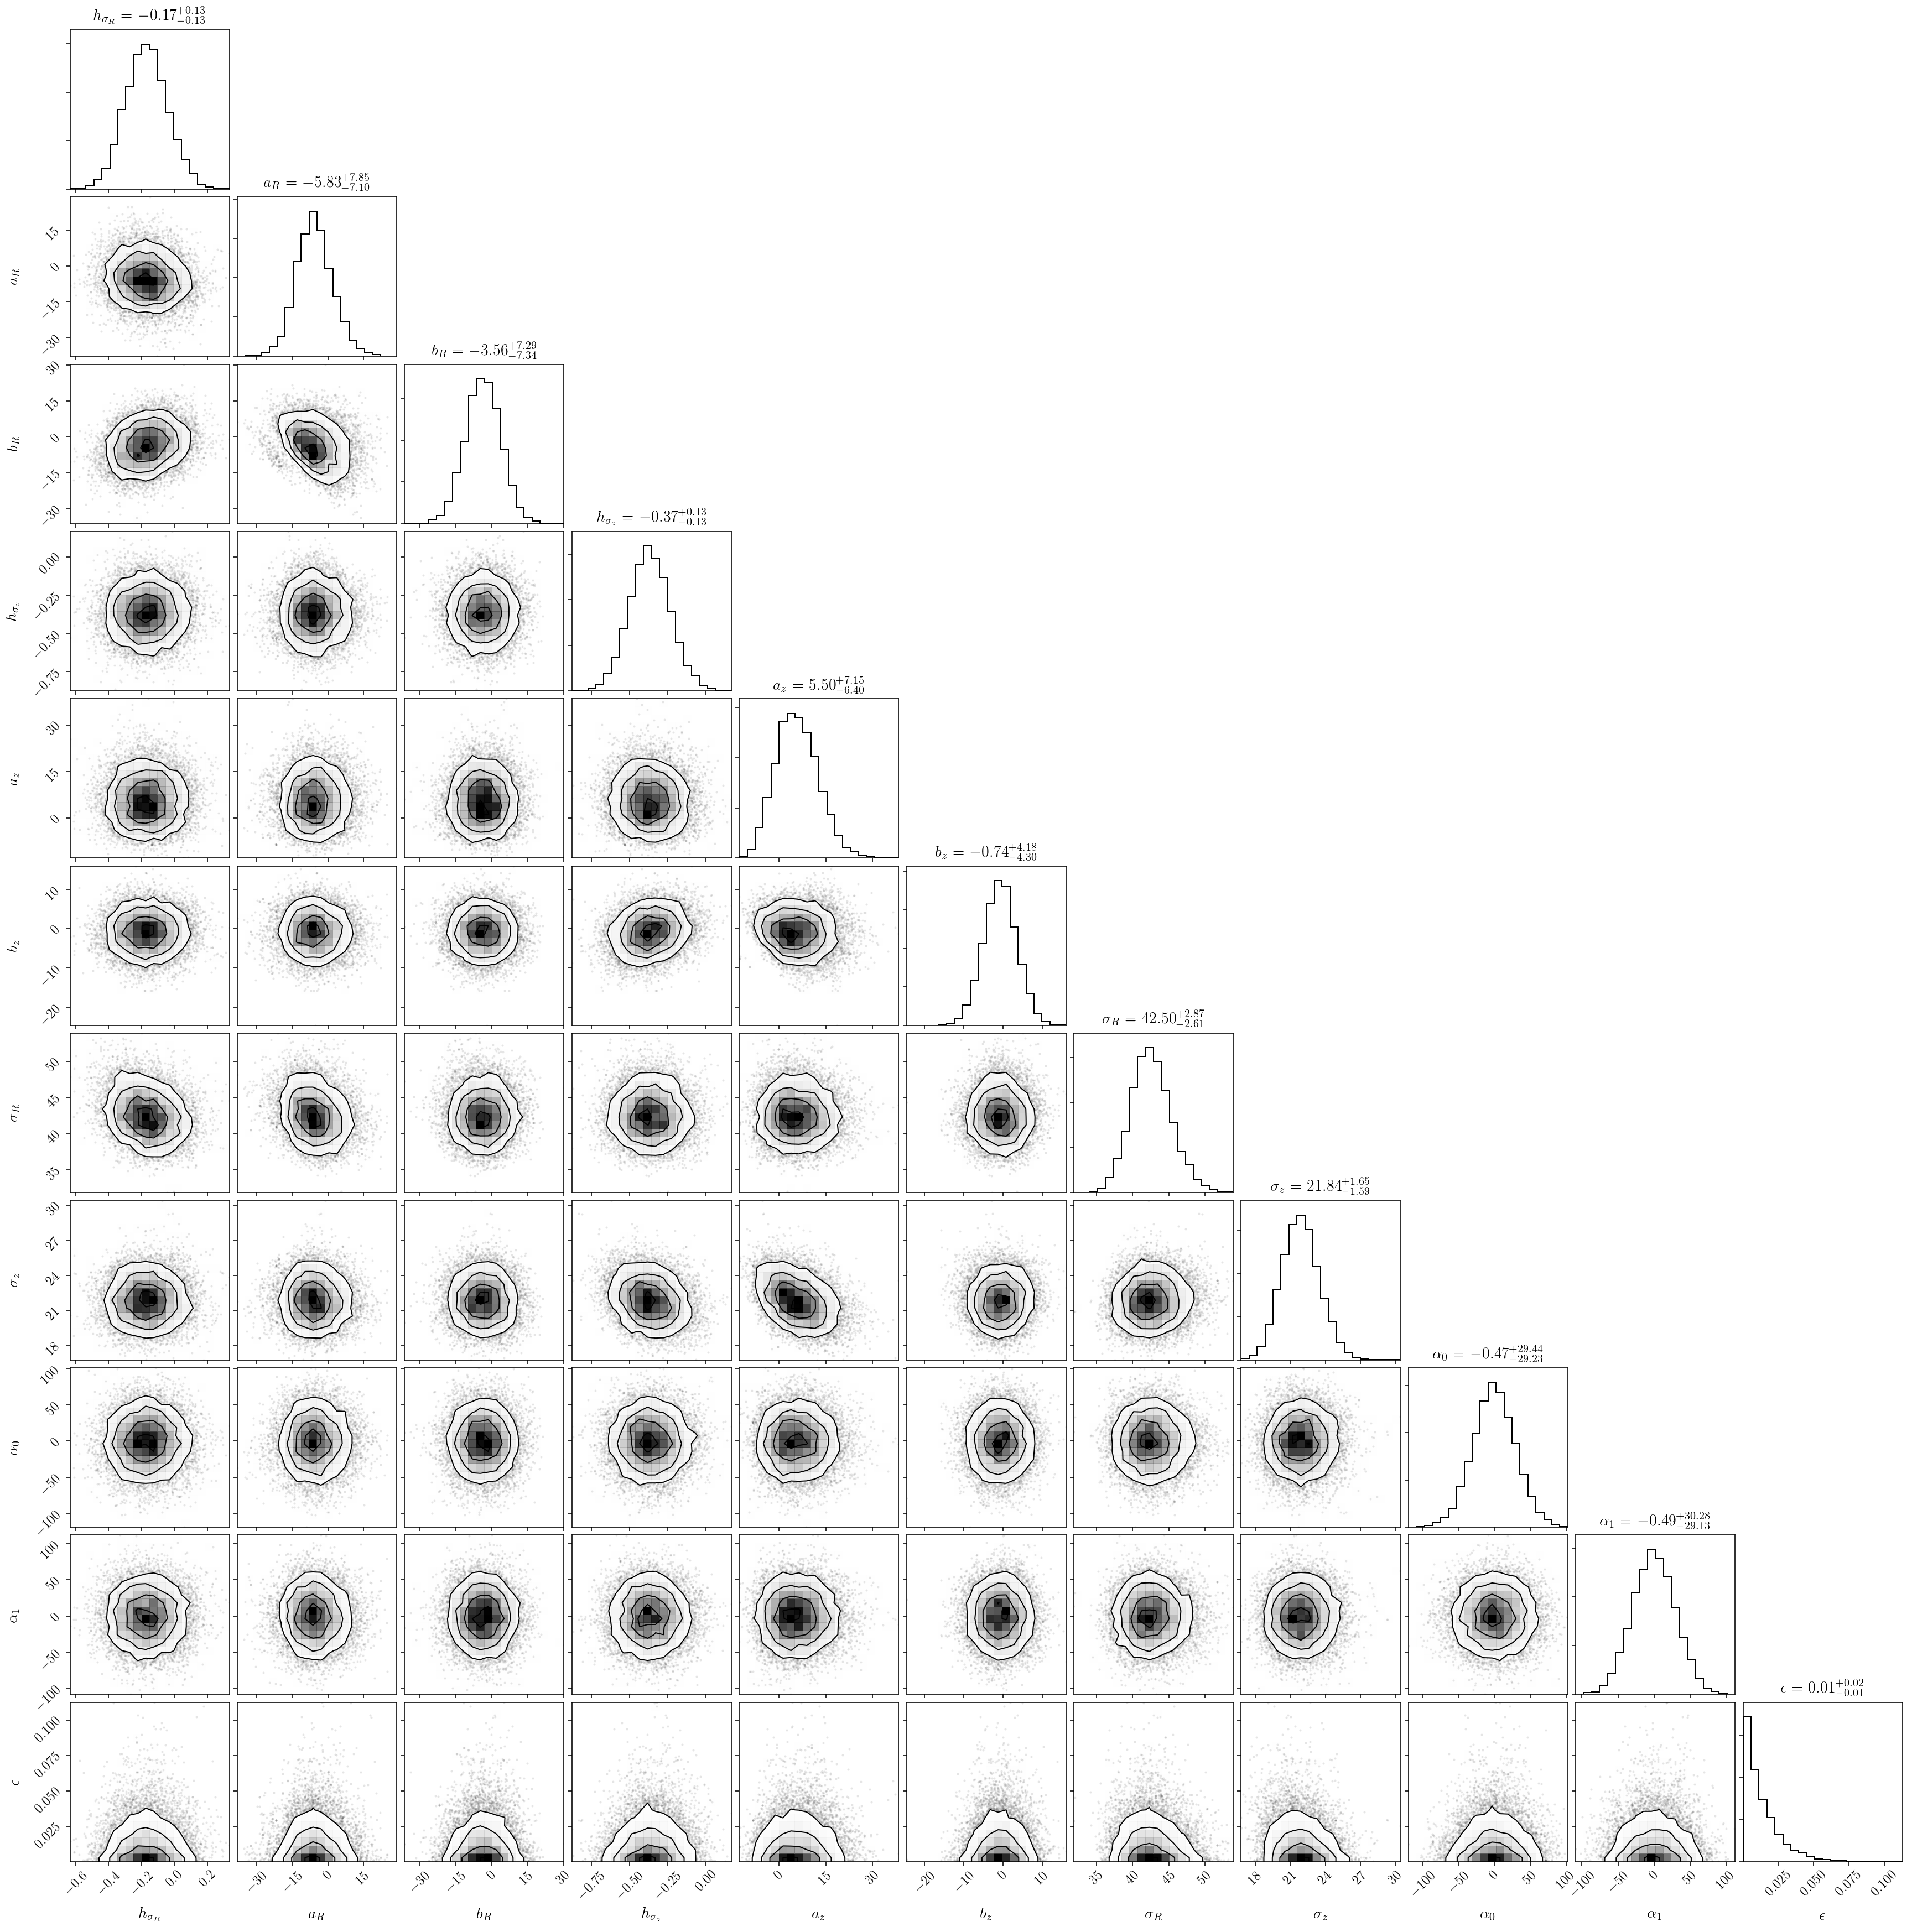

In [55]:
labels =[r'$h_{\sigma_{R}}$', r'$a_R$', r'$b_R$', r'$h_{\sigma_{z}}$', r'$a_z$', r'$b_z$', r'$\sigma_{R}$', r'$\sigma_{z}$',r'$\alpha_0$', r'$\alpha_1$', r'$\epsilon$']
fig = corner.corner(tsamp_arrs[0][i,j], labels = labels, show_titles=True)

In [ ]:
nit = 5000
nchain = 4
nsamples = int((nit/2)*nchain)
#pars=['invhR', 'aR', 'bR', 'invhz', 'az', 'bz', 'logsigmaR','v_R0', 'logsigmaz', 'v_z0', 'eta']
#pars = ['invhR_R', 'invhz_R', 'invhR_z', 'invhz_z', 'sigmaR', 'sigmaz', 'eta']
pars = ['sigmaR', 'sigmaz', 'eta']
agebins = np.arange(1.,14.,2.)
fehbins = np.arange(-0.6,0.6,0.1)
lo_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
hi_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
samp_arrs = [lo_samples, hi_samples]
labels = ['low', 'high']
for i in range(len(agebins)-1):
    for j in range(len(fehbins)-1):
        print(str(i)+','+str(j)+' '+str(agebins[i])+' < Age < '+str(agebins[i+1])+'  '+str(round(fehbins[j],2))+' < [Fe/H] < '+str(round(fehbins[j+1],2)))
        lo_m = [(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] < define_rgbtgassample.alphaedge(dat['FE_H'])) & (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
        hi_m = [(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] >= define_rgbtgassample.alphaedge(dat['FE_H']))& (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
        m = [lo_m, hi_m]
        for ii,mask in enumerate(m):
            v_R = vRvTvz[:,0][mask]*220.
            v_z = vRvTvz[:,2][mask]*220.
            R = Rpz[:,0][mask]*8.
            z = Rpz[:,2][mask]*8.
            e_vR2 = cov_galcencyl[:,0,0][mask]
            e_vz2 = cov_galcencyl[:,2,2][mask]
            if len(v_R) < 100:
                print('not enough samples in '+labels[ii]+' alpha...')
            else:
                dat_dict = {'N': len(v_R),
                            'vR': v_R,
                            'vz': v_z,
                            'R': R,
                            'z': np.fabs(z),
                            'e_vR2': e_vR2,
                            'e_vz2': e_vz2,
                            'med_z': np.median(np.fabs(z)),
                            'cont_sigma': 100.}
                print('sampling '+labels[ii]+' alpha...')
                fit = sm.sampling(data=dat_dict, iter=nit, chains=nchain, verbose=True)
                extr = fit.extract(pars=pars, permuted=True)
                samples = np.empty([nsamples,len(pars)])
                for k in range(len(pars)):
                    samples[:,k] = extr[pars[k]]
                print('sample means:'+np.str(np.mean(samples, axis=0)))
                samp_arrs[ii][i,j] = samples
with open('../sav/gaussian_isothermal_stanfit.npy', 'wb') as f:
    np.save(f, lo_samples)
    np.save(f, hi_samples)
    np.save(f, agebins)
    np.save(f, fehbins)

In [15]:
nit = 5000
nchain = 4
nsamples = int((nit/2)*nchain)
pars=['sigmaR', 'sigmaz', 'sigmaRz','alpha', 'eta']
#pars = ['invhR_R', 'invhz_R', 'invhR_z', 'invhz_z', 'sigmaR', 'sigmaz', 'eta']
#pars = ['sigmaR', 'sigmaz', 'eta']
agebins = np.arange(1.,14.,2.)
fehbins = np.arange(-0.6,0.6,0.1)
tlo_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
thi_samples = np.ones([len(agebins)-1, len(fehbins)-1, nsamples, len(pars)])*np.nan
tsamp_arrs = [tlo_samples, thi_samples]
labels = ['low', 'high']
i=3
j=5
print(str(agebins[i])+' < Age < '+str(agebins[i+1])+'  '+str(round(fehbins[j],2))+' < [Fe/H] < '+str(round(fehbins[j+1],2)))
lo_m = [(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] < define_rgbtgassample.alphaedge(dat['FE_H'])) & (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
hi_m = [(dat['Age'] > agebins[i]) & (dat['Age'] < agebins[i+1]) & (dat['FE_H'] > fehbins[j]) & (dat['FE_H'] < fehbins[j+1]) & (dat['AVG_ALPHAFE'] >= define_rgbtgassample.alphaedge(dat['FE_H']))& (np.sqrt(cov_galcencyl[:,0,0]) < 10) & (np.sqrt(cov_galcencyl[:,2,2]) < 10)]
m = [lo_m, hi_m]
for ii,mask in enumerate(m):
    v_R = vRvTvz[:,0][mask]*220.
    v_z = vRvTvz[:,2][mask]*220.
    vRvz = np.dstack([v_R, v_z])[0]
    R = Rpz[:,0][mask]*8.
    z = Rpz[:,2][mask]*8.
    cov = cov_galcencyl[mask]
    print(len(v_R))
    if len(v_R) < 100:
        print('not enough samples in '+labels[ii]+' alpha...')
    else:
        dat_dict = {'N': len(v_R),
                    'vRvz': vRvz,
                    'R': R,
                    'z': np.fabs(z),
                    'cov_galcencyl': cov,
                    'med_z': np.mean(np.fabs(z)),
                    'cont_sigma': 100.}
        print('sampling '+labels[ii]+' alpha...')
        fit = sm.sampling(data=dat_dict, iter=nit, chains=nchain, verbose=True)
        extr = fit.extract(pars=pars, permuted=True)
        samples = np.empty([nsamples,len(pars)])
        for k in range(len(pars)):
            samples[:,k] = extr[pars[k]]
        print('sample means:'+np.str(np.mean(samples, axis=0)))
        tsamp_arrs[ii][i,j] = samples

7.0 < Age < 9.0  -0.1 < [Fe/H] < -0.0
141
sampling low alpha...


sample means:[4.10455778e+01 2.14639149e+01 7.78861317e-03 5.53504572e-06
 1.76651923e-02]
226
sampling high alpha...


sample means:[5.59306846e+01 2.87179376e+01 1.14883073e+00 1.57243691e+00
 2.28151497e-02]


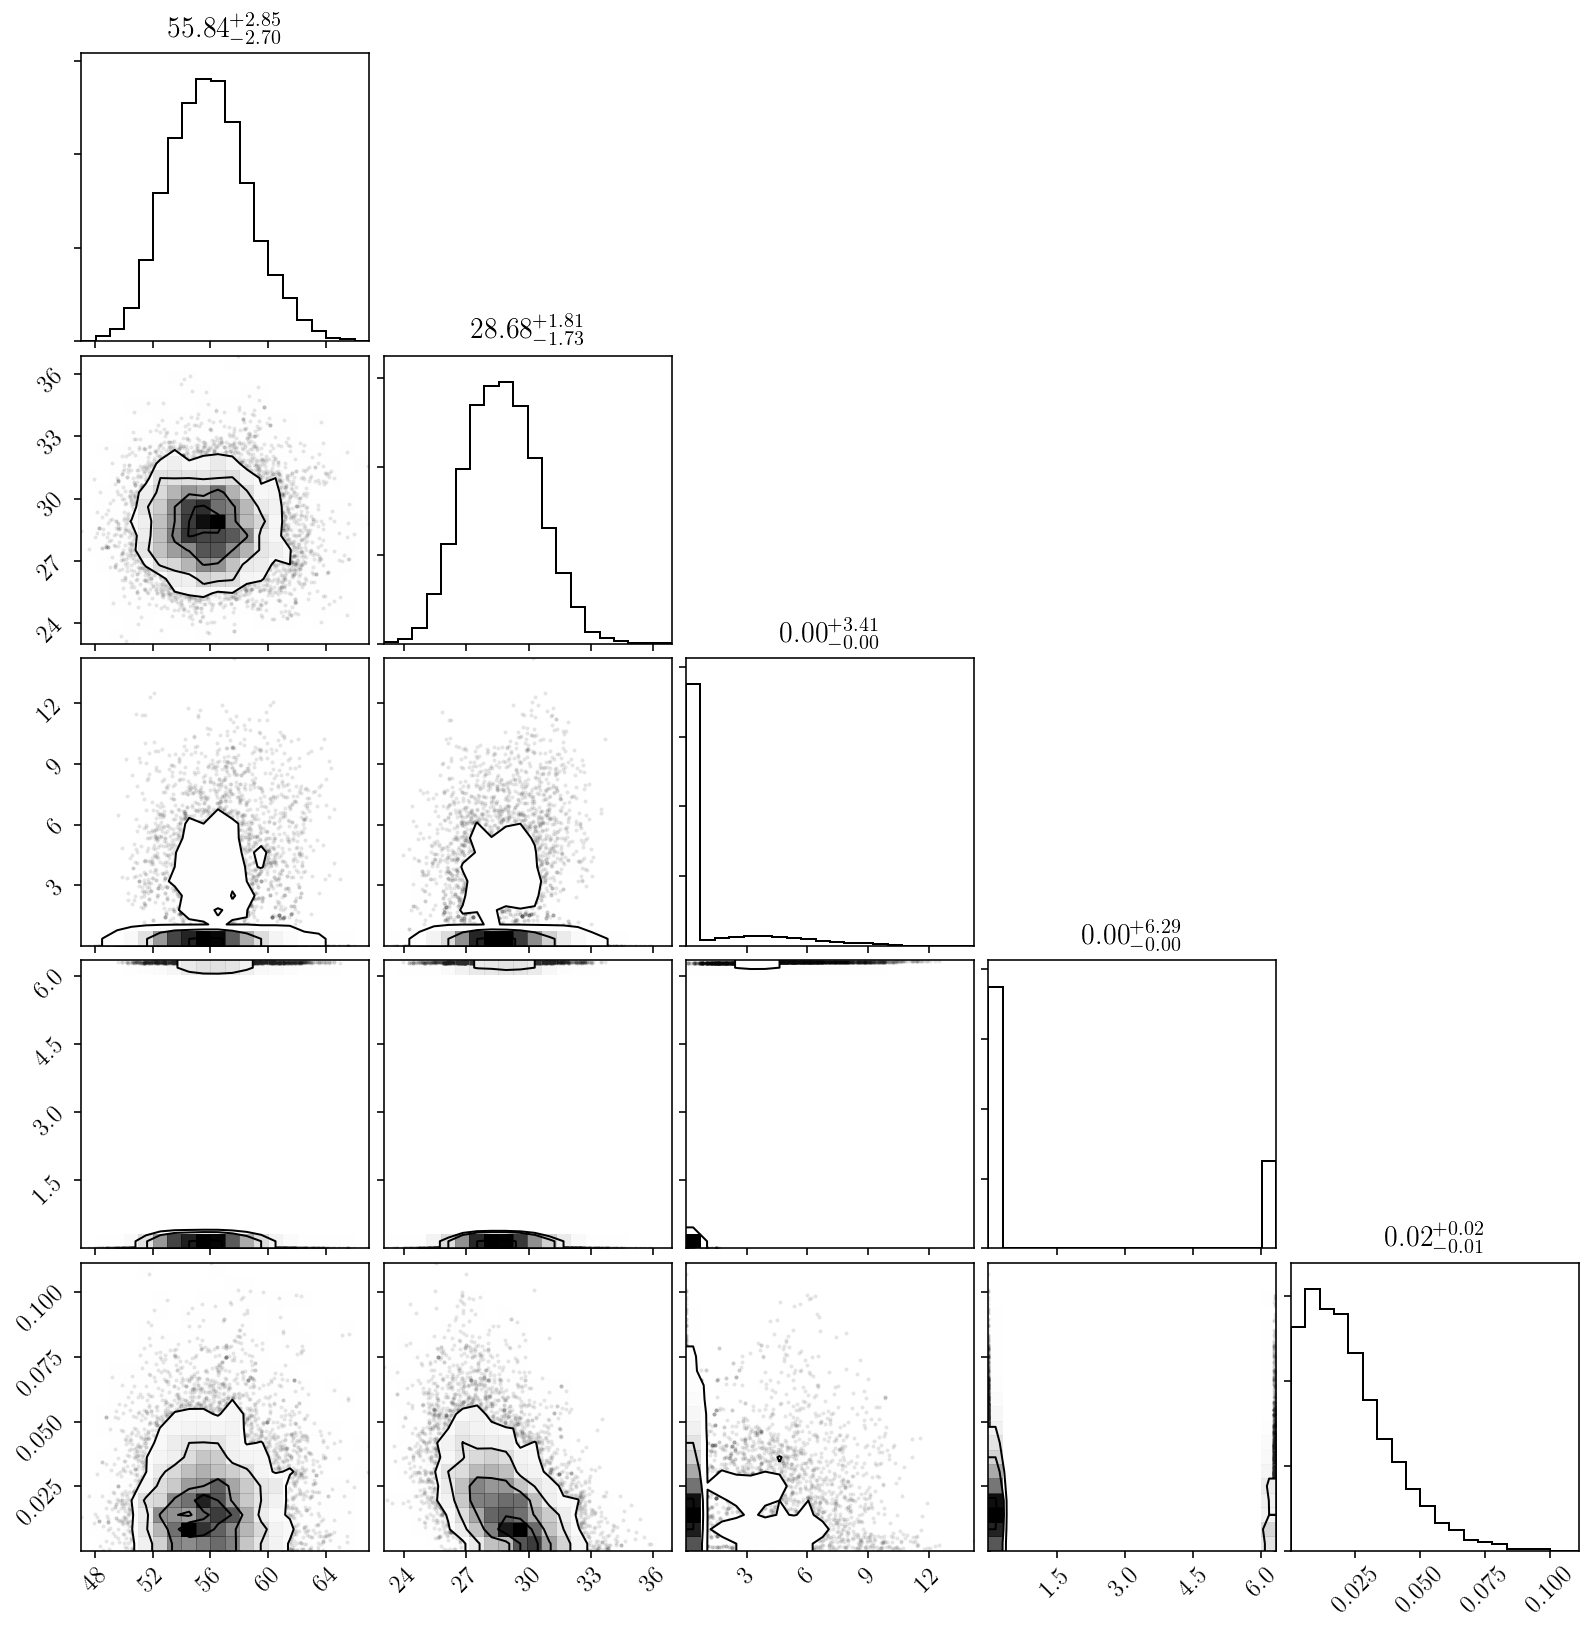

In [17]:
fig = corner.corner(tsamp_arrs[1][i,j], show_titles=True)

(-89.17831369990697,
 102.04449256181712,
 -121.01485279242694,
 103.43483520599698)

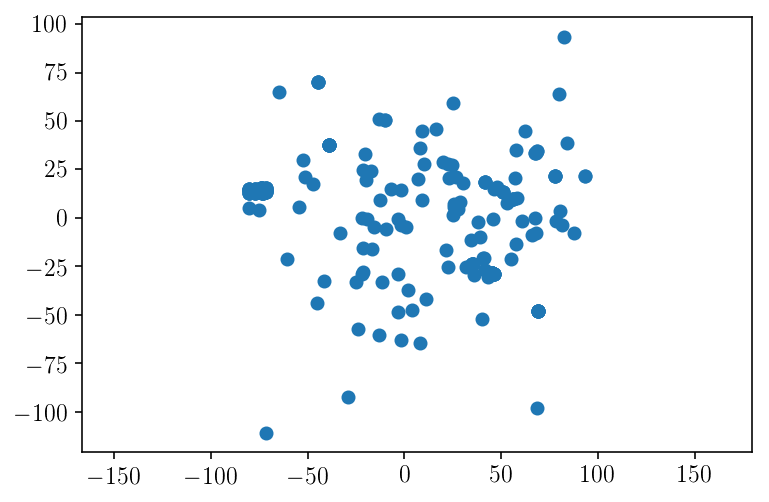

In [19]:
plt.scatter(v_R, v_z)
plt.axis('equal')